In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import datetime
global_start = datetime.datetime.now();
gpu_information = len(tf.config.list_physical_devices('GPU'))>0
print ("available" if gpu_information else "not available")

available


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [ ]:
size = 128
def dataset_load(src_path, data):
  base = os.listdir(src_path)
  base.sort()

  for folder in base:
    images = os.listdir(os.path.join(src_path, folder))
    images.sort()
    print("Load class '{}' = {} images".format(folder, len(images)))
    
    for image in tqdm(images):
      label = folder
      try:
        img = cv2.imread(os.path.join(src_path, folder, image))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (size,size), cv2.INTER_AREA)
      except:
        continue
      
      data.append([np.array(img), np.array(label)])
    print()
  
  random.shuffle(data)
  return data

In [ ]:
dataset = []
src_path = '/content/drive/MyDrive/Dataset/mangga/augmentasi4'
dataset = dataset_load(src_path, dataset)

Load class 'Class_I' = 1800 images


100%|██████████| 1800/1800 [00:43<00:00, 41.00it/s] 



Load class 'Class_II' = 1800 images


100%|██████████| 1800/1800 [00:29<00:00, 60.27it/s] 



Load class 'Ekstra_Class' = 1800 images


100%|██████████| 1800/1800 [00:30<00:00, 59.84it/s] 

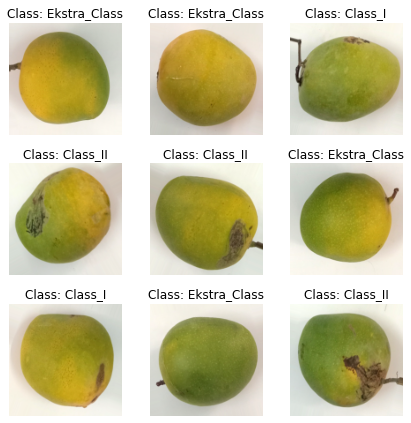

In [ ]:
fig, ax = plt.subplots(3,3)
fig.set_size_inches(6,6)
for i in range(3):
  for j in range (3):
    sample = random.choice(range(len(dataset)))
    ax[i,j].imshow(dataset[sample][0])
    ax[i,j].set_title('Class: '+str(dataset[sample][1]))
    ax[i,j].axis('off')
plt.tight_layout()

# Split Dataset

In [ ]:
x = np.array([i[0] for i in dataset]).reshape(-1,size,size,3)
y = np.array([i[1] for i in dataset])

In [ ]:
# Membuat label tiap kelas
label = {
    'Ekstra_Class' : 0,
    'Class_I' : 1,
    'Class_II' : 2,
}
y = np.vectorize(label.get)(y)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.85, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=y_train)
x_train = x_train/128.0
x_test = x_test/128.0
x_val = x_val/128.0

test_sample = x_test.copy()

print('Training size\t: X = {}\ty = {}'.format(len(x_train), len(y_train)))
print('Validation size\t: X = {}\ty = {}'.format(len(x_val), len(y_val)))
print('Testing size\t: X = {}\ty = {}'.format(len(x_test), len(y_test)))

Training size	: X = 3901	y = 3901
Validation size	: X = 689	y = 689
Testing size	: X = 810	y = 810


# Classification Model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
classification = ResNet50(input_shape = (size, size, 3), weights = 'imagenet', include_top = False)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
for layer in classification.layers:
    layer.trainable = False

x = Flatten()(classification.output)
prediction = Dense(3, activation='softmax')(x)

model = Model(inputs=classification.input, outputs=prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
plot_model(model=model, show_shapes=True)

# Optimizer

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# History Model Run

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss' ,verbose = 1, patience = 10)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose=1, factor=0.1, min_lr=0.001)
# callbacks = [early_stop, reduce_lr]
callbacks = [early_stop]

In [ ]:
history = model.fit(
    x_train, y_train,
    batch_size = 32,
    epochs = 50,
    validation_data = (x_val, y_val)
    # callbacks=callbacks,
    # shuffle=True
    )

print(datetime.datetime.now()-global_start)

Epoch 1/50
122/122 [==============================] - 26s 114ms/step - loss: 0.9839 - accuracy: 0.5124 - val_loss: 0.8747 - val_accuracy: 0.5994
Epoch 2/50
122/122 [==============================] - 13s 103ms/step - loss: 0.7965 - accuracy: 0.6547 - val_loss: 0.8024 - val_accuracy: 0.6110
Epoch 3/50
122/122 [==============================] - 12s 95ms/step - loss: 0.7359 - accuracy: 0.6742 - val_loss: 0.7073 - val_accuracy: 0.6981
Epoch 4/50
122/122 [==============================] - 12s 96ms/step - loss: 0.6726 - accuracy: 0.7211 - val_loss: 0.6575 - val_accuracy: 0.7373
Epoch 5/50
122/122 [==============================] - 12s 96ms/step - loss: 0.6432 - accuracy: 0.7365 - val_loss: 0.6321 - val_accuracy: 0.7634
Epoch 6/50
122/122 [==============================] - 12s 98ms/step - loss: 0.6101 - accuracy: 0.7478 - val_loss: 0.7225 - val_accuracy: 0.6618
Epoch 7/50
122/122 [==============================] - 12s 97ms/step - loss: 0.5810 - accuracy: 0.7680 - val_loss: 0.6119 - val_accurac

In [ ]:
def plot_training_history(history):
  plt.style.use('ggplot')
  fig = plt.figure(figsize=(16,6))
  
  plt.subplot(1,2,1)
  plt.plot(history.history['val_accuracy'], label='val acc')
  plt.plot(history.history['accuracy'], label='train acc')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend(['Validation Accuracy','Training Accuracy'], loc='lower right')
  
  plt.subplot(1,2,2)
  plt.plot(history.history['val_loss'], label='val loss')
  plt.plot(history.history['loss'], label='train loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend(['Validation Loss','Training Loss'], loc='upper right')
  plt.show()

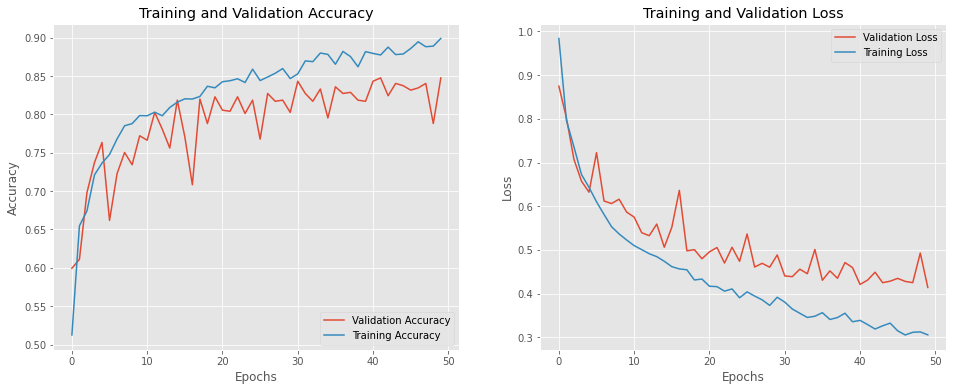

In [ ]:
  plot_training_history(history)

In [ ]:
print('Training Evaluation')
loss, acc = model.evaluate(x_train, y_train)
print('Loss\t\t:', loss)
print('Accuracy\t:', acc)

Training Evaluation
122/122 [==============================] - 10s 83ms/step - loss: 0.2790 - accuracy: 0.9144
Loss		: 0.2790372967720032
Accuracy	: 0.9143809080123901


In [ ]:
print('Validation Evaluation')
loss, acc = model.evaluate(x_val, y_val)
print('Loss\t\t:', loss)
print('Accuracy\t:', acc)

Validation Evaluation
22/22 [==============================] - 2s 80ms/step - loss: 0.4140 - accuracy: 0.8476
Loss		: 0.41403618454933167
Accuracy	: 0.8476052284240723


In [ ]:
print('Testing Evaluation')
loss, acc = model.evaluate(x_test, y_test)
print('Loss\t\t:', loss)
print('Accuracy\t:', acc)

Testing Evaluation
26/26 [==============================] - 3s 99ms/step - loss: 0.4317 - accuracy: 0.8272
Loss		: 0.43169084191322327
Accuracy	: 0.8271604776382446


In [ ]:
y_pred = np.argmax(model.predict(x_test), axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       270
           1       0.79      0.73      0.76       270
           2       0.89      0.86      0.87       270

    accuracy                           0.83       810
   macro avg       0.83      0.83      0.83       810
weighted avg       0.83      0.83      0.83       810



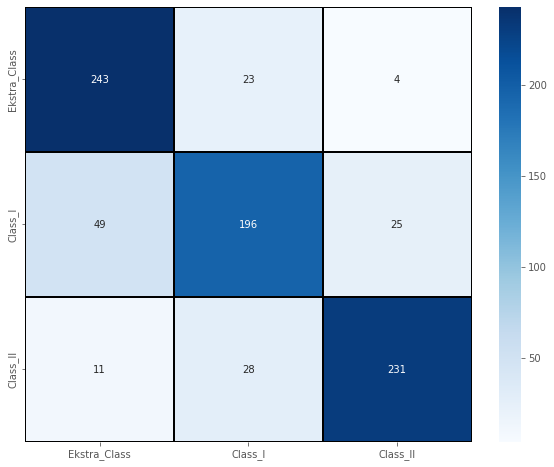

In [ ]:
L = list(label)
c_matrix = confusion_matrix(y_test, y_pred)
c_matrix = pd.DataFrame(c_matrix, index=L, columns=L)

plt.figure(figsize = (10,8))
sns.heatmap(c_matrix, cmap='Blues', linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=L, yticklabels=L)

In [ ]:
# model.save('/content/drive/MyDrive/Colab Notebooks/Model/vgg19_Adam_Baru.hdf5', overwrite=True, include_optimizer=True)